# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

#### German Traffic Sign Benchmark source

J. Stallkamp, M. Schlipsing, J. Salmen, and C. Igel. The German Traffic Sign Recognition Benchmark: A multi-class classification competition. In Proceedings of the IEEE International Joint Conference on Neural Networks, pages 1453–1460. 2011. 

## Load the Library

In [1]:
# Visualizations will be shown in the notebook.
%matplotlib inline

# Python library
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import cv2

# Files Handling
import os.path
import glob
import pickle
import csv

# Deep Learning Framework
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.contrib.layers import flatten

## Global Parameters

In [33]:
max_train_labels_per_class = 1250
max_valid_labels_per_class = 150

traffic_signs_data_folder = "traffic-signs-data/"
trained_model_folder = 'trained_models/best/'
csv_file = 'signnames.csv'

### Helper Function

In [3]:
def get_csv_signnames(fname):
    signnames = {}
    with open('signnames.csv') as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        class_index = []
        class_description = []
        for row in readCSV:
            class_index.append(row[0])
            class_description.append(row[1])
            signnames['class_index'] = class_index[1:]
            signnames['class_description'] = class_description[1:]
    return signnames

# Traffic sign indices and names
signnames = get_csv_signnames(csv_file)

def show_dataset_summary(labels,title='',hline=None):
    # Summary of dataset
    plt.figure(figsize=(14,6))
    plt.title(title)

    # Number of clsses
    n_classes = len(np.unique(labels))
    
    # Plot histogram
    n, bins, patches = plt.hist(labels, bins=np.arange(0,n_classes+1))
    hls = plt.xticks(range(0, n_classes+2))
    if hline == None:
        pass
    else:
        plt.axhline(y=hline, color='k', linestyle='dashed', linewidth=1)
    
    # Stats of the labels
    min_samples = min(np.bincount(labels))
    max_samples = max(np.bincount(labels))
    avg_samples = int(np.average(np.bincount(labels)))
    print("Minimum samples for any label:", min_samples)
    print("Maximum samples for any label:", max_samples)
    print("Average samples for any label:", avg_samples)
    print('')

def print_traffic_sign_class_count(labels,signnames):
    num_images_per_class = np.bincount(labels)
    total_num_images = len(num_images_per_class)
    
    print('-----------------------------------------------------')
    print('Overview of the training dataset of the traffic signs')
    print('-----------------------------------------------------')
    # Get traffic sign names from CSV
    for i in range(total_num_images):
        print('#{}:\t{}\t has {} counts'.format(i,signnames['class_description'][i],num_images_per_class[i]))
    print('')
    
def show_training_metrics(train_loss_results,train_accuracy_results,dataset_name=''):
    
    fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
    fig.suptitle('Training Metrics: ' + dataset_name)

    axes[0].set_ylabel("Loss", fontsize=14)
    axes[0].plot(train_loss_results)

    axes[1].set_ylabel("Accuracy", fontsize=14)
    axes[1].set_xlabel("Epoch", fontsize=14)
    axes[1].plot(train_accuracy_results)
    plt.show()

def save_dataset(fname,features,labels):
    # Save the dataset as pickle
    new_dataset = {}
    new_dataset["features"] = features
    new_dataset["labels"] = labels
    
    path = traffic_signs_data_folder + fname
    pickle.dump(new_dataset, open(path, "wb" ))

def load_dataset(path,verbose=False):
    if verbose:
        print('Loading pickle data file located in: ',path)
    fname = os.path.basename(path)
    fname_basename = os.path.splitext(fname)[0]

    dataset = pickle.load( open(path, "rb" ) )
    dataset['features'] = np.array(dataset['features'])
    dataset['labels'] = np.array(dataset['labels'])
    return dataset

---
## Step 0: Load The Data

In [4]:
# TODO: Fill this in based on where you saved the training and testing data

training_file   = 'traffic-signs-data/train.p'
validation_file = 'traffic-signs-data/valid.p'
testing_file    = 'traffic-signs-data/test.p'

# Open the pickle file
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [5]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test,  y_test  = test['features'], test['labels']

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of validation examples
n_valid = len(X_valid)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. **Is the distribution the same?** Are there more examples of some classes than others?

Minimum samples for any label: 180
Maximum samples for any label: 2010
Average samples for any label: 809

-----------------------------------------------------
Overview of the training dataset of the traffic signs
-----------------------------------------------------
#0:	Speed limit (20km/h)	 has 180 counts
#1:	Speed limit (30km/h)	 has 1980 counts
#2:	Speed limit (50km/h)	 has 2010 counts
#3:	Speed limit (60km/h)	 has 1260 counts
#4:	Speed limit (70km/h)	 has 1770 counts
#5:	Speed limit (80km/h)	 has 1650 counts
#6:	End of speed limit (80km/h)	 has 360 counts
#7:	Speed limit (100km/h)	 has 1290 counts
#8:	Speed limit (120km/h)	 has 1260 counts
#9:	No passing	 has 1320 counts
#10:	No passing for vehicles over 3.5 metric tons	 has 1800 counts
#11:	Right-of-way at the next intersection	 has 1170 counts
#12:	Priority road	 has 1890 counts
#13:	Yield	 has 1920 counts
#14:	Stop	 has 690 counts
#15:	No vehicles	 has 540 counts
#16:	Vehicles over 3.5 metric tons prohibited	 has 360 counts
#1

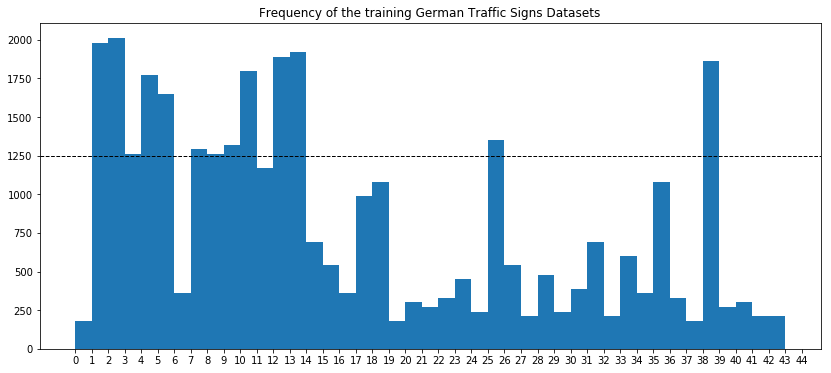

In [6]:
show_dataset_summary(y_train,title='Frequency of the training German Traffic Signs Datasets',hline=max_train_labels_per_class)
print_traffic_sign_class_count(y_train,signnames)

Minimum samples for any label: 30
Maximum samples for any label: 240
Average samples for any label: 102

-----------------------------------------------------
Overview of the training dataset of the traffic signs
-----------------------------------------------------
#0:	Speed limit (20km/h)	 has 30 counts
#1:	Speed limit (30km/h)	 has 240 counts
#2:	Speed limit (50km/h)	 has 240 counts
#3:	Speed limit (60km/h)	 has 150 counts
#4:	Speed limit (70km/h)	 has 210 counts
#5:	Speed limit (80km/h)	 has 210 counts
#6:	End of speed limit (80km/h)	 has 60 counts
#7:	Speed limit (100km/h)	 has 150 counts
#8:	Speed limit (120km/h)	 has 150 counts
#9:	No passing	 has 150 counts
#10:	No passing for vehicles over 3.5 metric tons	 has 210 counts
#11:	Right-of-way at the next intersection	 has 150 counts
#12:	Priority road	 has 210 counts
#13:	Yield	 has 240 counts
#14:	Stop	 has 90 counts
#15:	No vehicles	 has 90 counts
#16:	Vehicles over 3.5 metric tons prohibited	 has 60 counts
#17:	No entry	 has 12

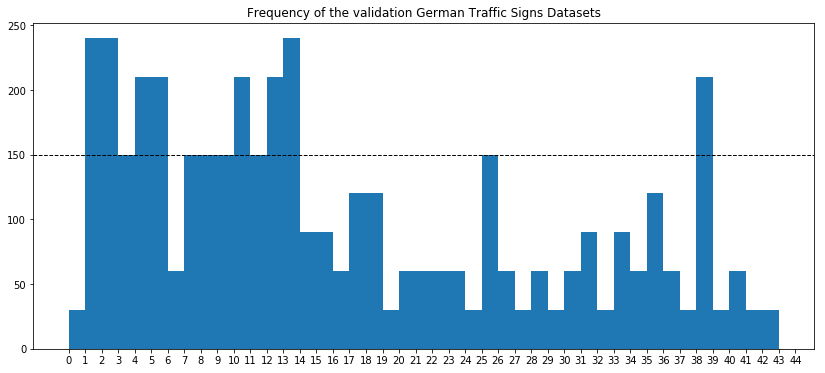

In [7]:
show_dataset_summary(y_valid,title='Frequency of the validation German Traffic Signs Datasets',hline=max_valid_labels_per_class)
print_traffic_sign_class_count(y_valid,signnames)

Minimum samples for any label: 30
Maximum samples for any label: 240
Average samples for any label: 102

-----------------------------------------------------
Overview of the training dataset of the traffic signs
-----------------------------------------------------
#0:	Speed limit (20km/h)	 has 60 counts
#1:	Speed limit (30km/h)	 has 720 counts
#2:	Speed limit (50km/h)	 has 750 counts
#3:	Speed limit (60km/h)	 has 450 counts
#4:	Speed limit (70km/h)	 has 660 counts
#5:	Speed limit (80km/h)	 has 630 counts
#6:	End of speed limit (80km/h)	 has 150 counts
#7:	Speed limit (100km/h)	 has 450 counts
#8:	Speed limit (120km/h)	 has 450 counts
#9:	No passing	 has 480 counts
#10:	No passing for vehicles over 3.5 metric tons	 has 660 counts
#11:	Right-of-way at the next intersection	 has 420 counts
#12:	Priority road	 has 690 counts
#13:	Yield	 has 720 counts
#14:	Stop	 has 270 counts
#15:	No vehicles	 has 210 counts
#16:	Vehicles over 3.5 metric tons prohibited	 has 150 counts
#17:	No entry	 ha

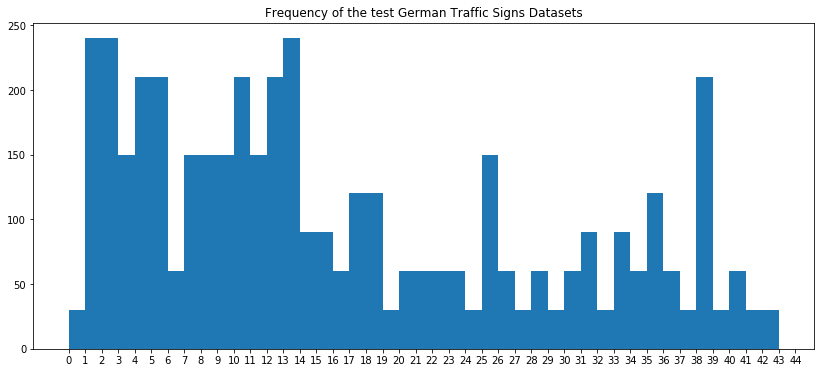

In [8]:
show_dataset_summary(y_valid,title='Frequency of the test German Traffic Signs Datasets')
print_traffic_sign_class_count(y_test,signnames)

In [9]:
def flatten_list(in_list):
    # Flattern 2D list to array
    flat_list = []
    # Flatten the 2D list
    for i in range(len(in_list)):
        for j in range(len(in_list[i])):
            flat_list.append(in_list[i][j])
    return np.array(flat_list)

def generate_underfit_class(labels,max_labels=0):
    # If no max number of labels, set the lowest
    # number labels across all traffic classes
    min_labels = min(np.bincount(labels))
    if (max_labels <= 0):
        max_labels = min_labels
    
    underfit_class = []
    n_classes = len(np.bincount(labels))
    for class_num in range(n_classes):
        num = np.bincount(labels)[class_num]
        if (num < max_labels):
            underfit_class.append(class_num)
    return underfit_class

def find_traffic_sign_class(sign_class,features,labels,max_labels):
    new_features = []
    new_labels = []
    
    # Look for the matching traffic sign class
    for i in range(len(features)):
        if (labels[i] == sign_class):
            new_features.append(features[i])
            new_labels.append(labels[i])
    
    # Limit the traffic sign data to the max number of samples
    if (len(new_features) > max_labels):
        new_features = new_features[0:max_labels]
        new_labels = new_labels[0:max_labels]
        # Optional save extracted traffic sign data
        #save_traffic_signs_data(features,labels,sign_class,'overfit')
    else:
        #print('Traffic Sign Class #class_{} has {} images'.format(sign_class,len(new_features)))
        # Optional save extracted traffic sign data
        #save_traffic_signs_data(features,labels,sign_class,'underfit')
        pass
    
    return new_features, new_labels

def save_traffic_signs_data(features,labels,class_num,freetext=''):
    # Data
    traffic_signs_data = {}
    traffic_signs_data['class'] = class_num
    traffic_signs_data['size'] = len(features)
    traffic_signs_data['features'] = features
    traffic_signs_data['labels'] = labels
    
    # Save the underfit traffic signs data
    path = traffic_signs_data_folder + freetext + '_class_' + str(class_num) + '.p'
    pickle.dump(traffic_signs_data, open(path, "wb" ))
    print('Saving pickle data in: ',path)

def create_new_dataset(features,labels,max_labels,output='array'):
    new_features = []
    new_labels = []
    total_num_class = len(np.unique(labels))
    
    # Create a new dataset with max number of labels for each traffic sign class
    for i in range(0, total_num_class):
        traffic_sign_class_features, traffic_sign_class_labels = find_traffic_sign_class(i,features,labels,max_labels)
        new_features.append(traffic_sign_class_features)
        new_labels.append(traffic_sign_class_labels)
    
    # return the new dataset as list if specified
    if output == 'list':
        return new_features, new_labels
    else:
        # Convert the lists to arrays
        new_features = flatten_list(new_features)
        new_labels = flatten_list(new_labels)
        return new_features, new_labels

### Trimmed the original (training) German Traffic Sign Datasets

Minimum samples for any label: 180
Maximum samples for any label: 1250
Average samples for any label: 690



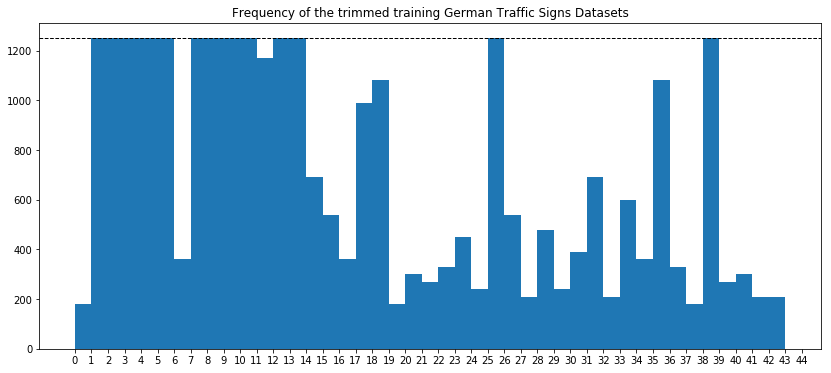

In [10]:
# Load the original German traffic sign datasets
with open(training_file, mode='rb') as f:
    original_train = pickle.load(f)
original_X_train, original_y_train = original_train['features'], original_train['labels']

# Set the maximum number of traffic signs allowed per class
underfit_train_class = generate_underfit_class(original_y_train,max_labels=max_train_labels_per_class)

# Create a new traffic sign dataset that has a more even distribution of the signs
trimmed_X_train, trimmed_y_train = create_new_dataset(original_X_train,original_y_train,max_labels=max_train_labels_per_class)

# Show the dataset summary
show_dataset_summary(trimmed_y_train,title='Frequency of the trimmed training German Traffic Signs Datasets',hline=max_train_labels_per_class)

# [Optional] Save trimmed dataset
# save_dataset('trimmed_train.p',trimmed_X_train,trimmed_y_train)

### Trimmed the original (validation) German Traffic Sign Datasets

Minimum samples for any label: 30
Maximum samples for any label: 150
Average samples for any label: 89



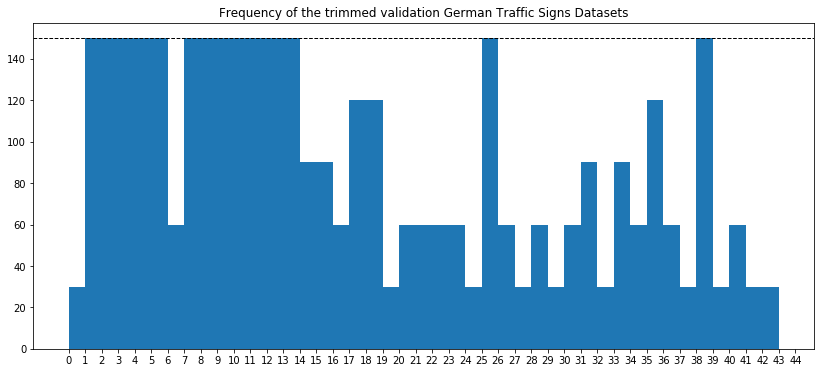

In [11]:
# Load the original German traffic sign datasets
with open(validation_file, mode='rb') as f:
    original_valid = pickle.load(f)
original_X_valid, original_y_valid = original_valid['features'], original_valid['labels']

# Set the maximum number of traffic signs allowed per class
underfit_valid_class = generate_underfit_class(original_y_valid,max_labels=max_valid_labels_per_class)

# Create a new traffic sign dataset that has a more even distribution of the signs
trimmed_X_valid, trimmed_y_valid = create_new_dataset(original_X_valid,original_y_valid,max_labels=max_valid_labels_per_class)

# Show the dataset summary
show_dataset_summary(trimmed_y_valid,title='Frequency of the trimmed validation German Traffic Signs Datasets',hline=max_valid_labels_per_class)

# [Optional] Save trimmed dataset
# save_dataset('trimmed_valid.p',trimmed_X_valid,trimmed_y_valid)

### Image Data Augmentation

In [12]:
# Image Data Augmentation
def horizotal_flip(img):
    #return np.fliplr(img)
    return cv2.flip(img, 1)
    
def vertical_flip(img):
    #return np.flipup(img)
    return cv2.flip(img,0)

def both_flips(img):
    return cv2.flip(img,-1)

def random_translate(img,px=2):
    height, width = img.shape[:2]
    
    # Generate random pixels translation in x and y directions
    fx,fy = np.random.randint(-px,px,2)

    M = np.float32([[1,0,fx],
                    [0,1,fy]])
    translated_img = cv2.warpAffine(img,M,(width,height))    
    return translated_img

def random_rotate(img, angle):
    # Rotation angle in degrees.
    # Positive values mean counter-clockwise rotation
    # (the coordinate origin is assumed to be the top-left corner).
    
    height, width = img.shape[:2]    
    # Center of the image
    mid_width = int(width/2)
    mid_height = int(height/2)

    # Rotate the image clockwise
    M = cv2.getRotationMatrix2D((mid_width, mid_height),-angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
 
    # compute the new bounding dimensions of the image
    new_width = int((height * sin) + (width * cos))
    new_hight = int((height * cos) + (width * sin))
 
    # adjust the rotation matrix to take into account translation
    M[0,2] += (new_width / 2) - mid_width
    M[1,2] += (new_hight / 2) - mid_height
 
    # perform the actual rotation and return the image
    return cv2.warpAffine(img, M, (new_width, new_hight))

# This function is not being used for batch processing image
# as it is computation intensive
def random_scale(img,aspect_pct=100):
    min_aspect_pct = 1

    # Fix one of the x scale to roughly half of the y scale
    # This is in avoid excessive image distortion
    fx = aspect_pct / 2
    fy = np.random.randint(min_aspect_pct,aspect_pct)
    return cv2.resize(img,None,fx=fx,fy=fy,interpolation=cv2.INTER_LINEAR)

def random_zoom(img,scaling_pct=80):   
    height, width = img.shape[:2]
    
    if (scaling_pct >= 100):
        return img
    
    reduce_px_x = int(height*(100-scaling_pct)/100)
    reduce_px_y = int(width*(100-scaling_pct)/100)

    # Generate random pixels to reduce in x and y directions
    fx,fy = np.random.randint(-reduce_px_x,reduce_px_y,2)

    # Original image corners
    # corners_coordinates = [top left, bottom left, top right, right bottom]
    src = np.float32([[0,0],[height,0],[0,width],[height,width]])
    
    # New image corners
    # corners_coordinates = [top left, bottom left, top right, right bottom]
    dst = np.float32([[fy,fx],[height-fy,fx],[fy,width-fx],[height-fy,width-fx]])

    M = cv2.getPerspectiveTransform(src,dst)
    warped_img = cv2.warpPerspective(img,M,(height,width),flags=cv2.INTER_LINEAR)
    return warped_img

def random_brightness(img,bright_adjust_range=127):
    # Maximum brightness adjustment range
    brightness_adjust = np.random.randint(-bright_adjust_range,bright_adjust_range)
    brightness_adjust = np.uint(brightness_adjust) # casting it to uint8
    
    # Adjust the brightness channel with the random value
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)   
    h, s, v = cv2.split(img) #uint8
    v += brightness_adjust
    img = cv2.merge((h, s, v))
    return cv2.cvtColor(img, cv2.COLOR_HSV2RGB)

def show_image(image):
    # Read in an image
    image = mpimg.imread(image)

    # Print out image dimensions and plotting
    print('This image is:', type(image), 'with dimensions:', image.shape)
    plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')
    return image

def save_augmented_images(augmented_img,augment_style,verbose=False):
    if verbose:
        print('Saving pickle data file in: ',path)
    path = traffic_signs_data_folder + augment_style + '.p'
    
    augmented_images = {}
    augmented_images[augment_style] = augmented_img
    
    # Save the augmented traffic signs data
    pickle.dump(augmented_images, open(path, "wb" ))

def generate_augmented_images(features,labels,save=False):
    # Initalize the list for datasets
    features_horizontal_flip_list = []
    features_vertical_flip_list = []
    features_both_flips_list = []
    features_random_translate_list = []
    features_random_zoom_list = []
    features_random_brightness_list = []

    # Initialize the list for the combined augmentation
    features_augmented = []
    labels_augmented = []
    
    n_train = len(features)
    for i in range(n_train):        
        # Apply the augmentation algorithm to the image
        features_horizontal_flip = horizotal_flip(features[i])
        features_vertical_flip = vertical_flip(features[i])
        features_both_flips = both_flips(features[i])
        features_random_translate = random_translate(features[i],px=16)
        features_random_zoom = random_zoom(features[i],scaling_pct=80)
        features_random_brightness = random_brightness(features[i],bright_adjust_range=128)
        
        # Add the augmentated images to the lists
        features_horizontal_flip_list.append(horizotal_flip(features[i]))
        features_vertical_flip_list.append(vertical_flip(features[i]))
        features_both_flips_list.append(both_flips(features[i]))
        features_random_translate_list.append(random_translate(features[i],px=16))
        features_random_zoom_list.append(random_zoom(features[i],scaling_pct=80))
        features_random_brightness_list.append(random_brightness(features[i],bright_adjust_range=128))
        
        # Merge all the augmented images into a single list
        features_augmented.append(features_horizontal_flip)
        features_augmented.append(features_vertical_flip)
        features_augmented.append(features_both_flips)
        features_augmented.append(features_random_translate)
        features_augmented.append(features_random_zoom)
        features_augmented.append(features_random_brightness)

        labels_augmented.append(labels[i])
        labels_augmented.append(labels[i])
        labels_augmented.append(labels[i])
        labels_augmented.append(labels[i])
        labels_augmented.append(labels[i])
        labels_augmented.append(labels[i])
    
    # Save the augemented data
    if save:
        save_augmented_images(features_horizontal_flip_list,'features_horizontal_flip')
        save_augmented_images(features_vertical_flip_list,'features_vertical_flip')
        save_augmented_images(features_both_flips_list,'features_both_flips')
        save_augmented_images(features_random_translate_list,'features_random_translate')
        save_augmented_images(features_random_zoom_list,'features_random_zoom')
        save_augmented_images(features_random_brightness_list,'features_random_brightness')

    # Convert the list to array
    features_augmented = np.asarray(features_augmented)
    labels_augmented = np.asarray(labels_augmented)
    return features_augmented, labels_augmented

def limit_max_label_per_class(X_train,Y_train,max_samples):
    n_classes = len(X_train)
    for sign_class in range(n_classes):
        X_train[sign_class] = X_train[sign_class][0:max_samples]
        Y_train[sign_class] = Y_train[sign_class][0:max_samples]
    return X_train, Y_train

def select_class_data(features,labels,class_index):
    selected_class_features = []
    selected_class_labels = []
    
    # Look for the matching traffic sign class
    for i in range(len(labels)):
            if (labels[i] == class_index):
                selected_class_features.append(features[i])
                selected_class_labels.append(labels[i])
    
    selected_class_data = {}
    selected_class_data['features'] = np.array(selected_class_features)
    selected_class_data['labels'] = np.array(selected_class_labels)
    
    return selected_class_data

def merge_underfitting_dataset(features,labels,underfit_class,max_samples):
    # for every underfit traffic sign class
    for underfit_class_index in underfit_class:
        # Load underfitting traffic signs
        path = 'traffic-signs-data/underfit/underfit_class_' + str(underfit_class_index) + '.p'

        # Extract the underfitting class
        underfit_data_features = features[underfit_class_index]
        underfit_data_labels = labels[underfit_class_index]
        
        # Generate different kind of image augmentation and shuffle them
        X_augmented, y_augmented = generate_augmented_images(underfit_data_features,underfit_data_labels)
        # Shuffle all the augmented data before combining with the original data
        X_augmented, y_augmented = shuffle(X_augmented, y_augmented)
        
        # Adding the augmented data to the underfitting data
        for i in range(len(X_augmented)):
            features[underfit_class_index].append(X_augmented[i])
            labels[underfit_class_index].append(y_augmented[i])

    # Trim the combined augmented traffic signs with the maximum samples
    features, labels = limit_max_label_per_class(features,labels,max_samples)
    
    # Unpack the nested list to a flat array like the original dataset
    new_X_train = flatten_list(features)
    new_y_train = flatten_list(labels)

    return new_X_train, new_y_train

Minimum samples for any label: 1250
Maximum samples for any label: 1250
Average samples for any label: 1250



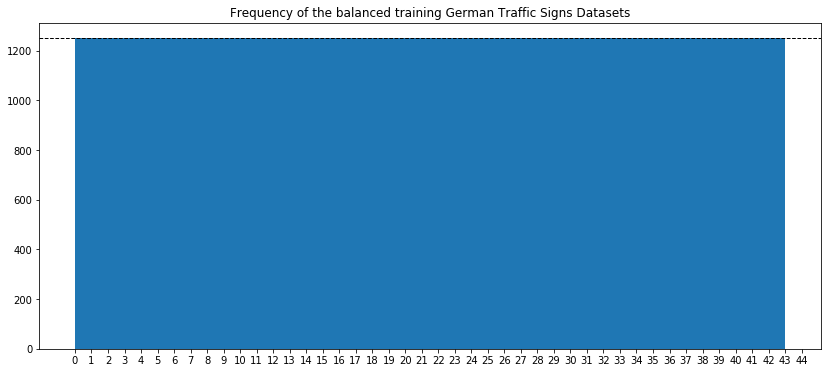

In [13]:
# Create balanced training dataset that fills up the gap of underfitting class to max_train_labels_per_class
# with augmented data
underfit_train_class = generate_underfit_class(original_y_train,max_train_labels_per_class)
trimmed_X_train, trimmed_y_train = create_new_dataset(original_X_train,original_y_train,max_train_labels_per_class,output='list')

balanced_X_train, balanced_y_train = merge_underfitting_dataset(trimmed_X_train,trimmed_y_train,underfit_train_class,max_train_labels_per_class)
show_dataset_summary(balanced_y_train,title='Frequency of the balanced training German Traffic Signs Datasets',hline=max_train_labels_per_class)

# [Optional] Save balanced dataset
# save_dataset('balanced_train.p',balanced_X_train,balanced_y_train)

Minimum samples for any label: 150
Maximum samples for any label: 150
Average samples for any label: 150



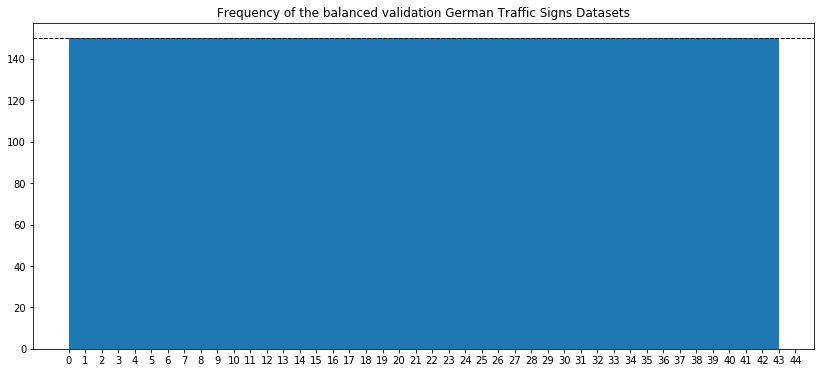

In [14]:
# Create balanced validation dataset that fills up the gap of underfitting class to max_train_labels_per_class
# with augmented data

underfit_valid_class = generate_underfit_class(original_y_valid,max_valid_labels_per_class)
trimmed_X_valid, trimmed_y_valid = create_new_dataset(original_X_valid,original_y_valid,max_valid_labels_per_class,output='list')

balanced_X_valid, balanced_y_valid = merge_underfitting_dataset(trimmed_X_valid,trimmed_y_valid,underfit_valid_class,max_valid_labels_per_class)
show_dataset_summary(balanced_y_valid,title='Frequency of the balanced validation German Traffic Signs Datasets',hline=max_valid_labels_per_class)

# [Optional] Save balanced dataset
#save_dataset('balanced_valid.p',balanced_X_valid,balanced_y_valid)

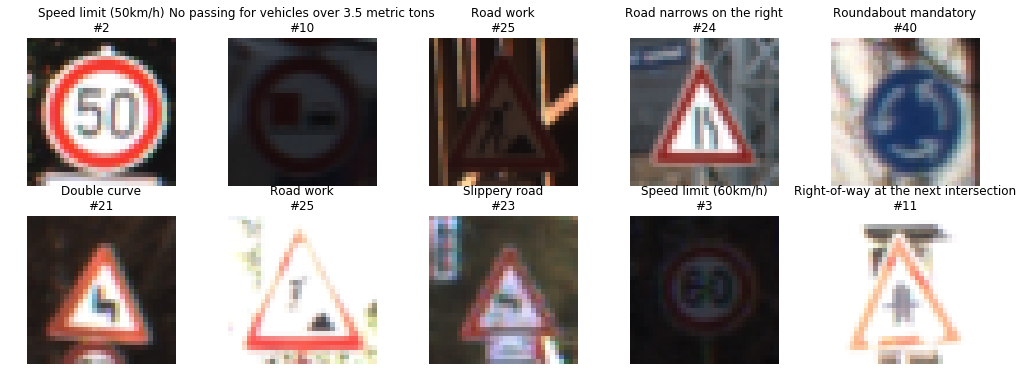

In [15]:
def show_first_x_random_traffic_signs(X_train,y_train,signnames,num):
    cols = 5
    rows = num//cols
    
    fig, ax = plt.subplots(rows,cols, figsize=(18, 6))
    fig.subplots_adjust(hspace = .2, wspace=.001)
    ax = ax.ravel()

    # Loop through each random sampled image
    for i in range(num):
        index = random.randint(0, len(X_train))
        image = X_train[index].squeeze()
        traffic_class_index = y_train[index]
        ax[i].set_title('{}\n#{}'.format(signnames['class_description'][traffic_class_index],traffic_class_index))
        ax[i].imshow(image,cmap='gray')
        ax[i].axis('off')
        
# Sample and show 10 random images
show_first_x_random_traffic_signs(X_train,y_train,signnames,10)

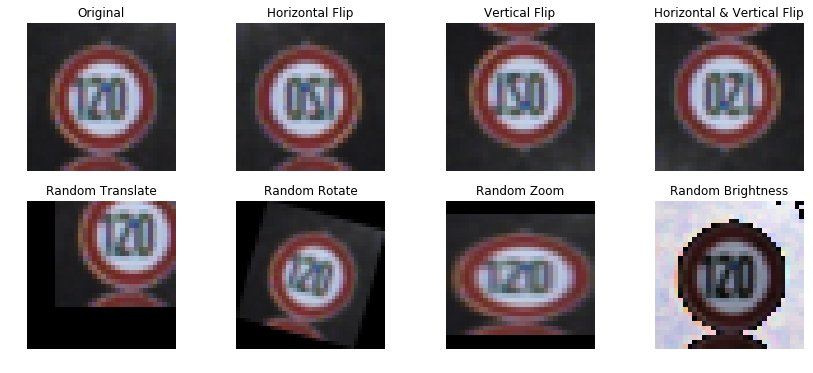

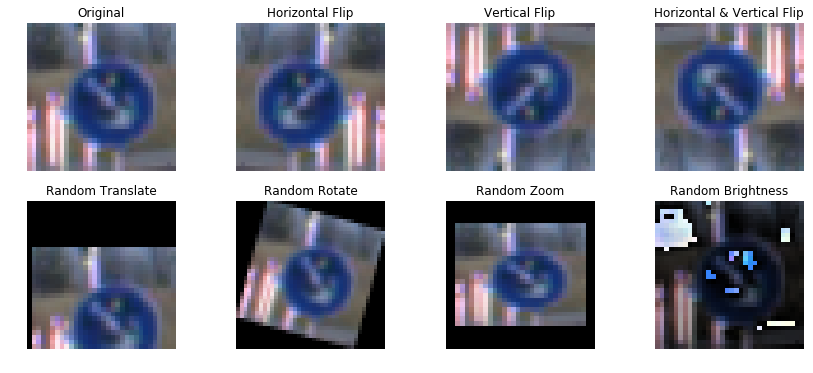

In [18]:
def show_image_augmentation(img,traffic_class_index):
    fig, ax = plt.subplots(2,4, figsize=(15, 6))
    
    fig.subplots_adjust(hspace = .2, wspace=.001)
    ax = ax.ravel()
    
    plt.title('#{}'.format(traffic_class_index))
    
    ax[0].set_title('Original')
    ax[0].imshow(img,cmap='gray')
    ax[0].axis('off')

    ax[1].set_title('Horizontal Flip')
    ax[1].imshow(horizotal_flip(img),cmap='gray')
    ax[1].axis('off')
    
    ax[2].set_title('Vertical Flip')
    ax[2].imshow(vertical_flip(img),cmap='gray')
    ax[2].axis('off')
    
    ax[3].set_title('Horizontal & Vertical Flip')
    ax[3].imshow(both_flips(img),cmap='gray')
    ax[3].axis('off')
    
    ax[4].set_title('Random Translate')
    ax[4].imshow(random_translate(img,px=16),cmap='gray')
    ax[4].axis('off')
    
    ax[5].set_title('Random Rotate')
    ax[5].imshow(random_rotate(img,15),cmap='gray')
    ax[5].axis('off')
    
    ax[6].set_title('Random Zoom')
    ax[6].imshow(random_zoom(img,scaling_pct=80),cmap='gray')
    ax[6].axis('off')
    
    ax[7].set_title('Random Brightness')
    ax[7].imshow(random_brightness(img,bright_adjust_range=128),cmap='gray')
    ax[7].axis('off')

# Show and compare augmentation of a speed sign
sign_120_index = 16005
show_image_augmentation(X_train[sign_120_index],sign_120_index)

# Show and compare augmentation of a random sampled sign
random_index = random.randint(0, len(X_train))
show_image_augmentation(X_train[random_index],random_index)

### Optional tools used to merge the augmented datasets

In [19]:
# Generate and save augument imges in pickle
# generate_augmented_images(X_train,y_train,save=False)
    
def load_augmented_images(path,verbose=False):
    if verbose:
        print('Loading pickle data file located in: ',path)  
    fname = os.path.basename(path)
    fname_basename = os.path.splitext(fname)[0]
    
    augmented_traffic_signs_data = pickle.load( open(path, "rb" ) )
    return np.array(augmented_traffic_signs_data[fname_basename])

# Load all the augmented datasets and save it as one pickle file
def load_and_save_all_augmented_images(X_train,y_train):
    augmented_traffic_signs_data = glob.glob(traffic_signs_data_folder+'X_train*.p')

    X_train_vertical_flip = load_augmented_images(traffic_signs_data_folder+'X_train_vertical_flip.p')
    X_train_horizontal_flip = load_augmented_images(traffic_signs_data_folder+'X_train_horizontal_flip.p')
    X_train_both_flips = load_augmented_images(traffic_signs_data_folder+'X_train_both_flips.p')

    X_train_random_brightness = load_augmented_images(traffic_signs_data_folder+'X_train_random_brightness.p')
    X_train_random_translate = load_augmented_images(traffic_signs_data_folder+'X_train_random_translate.p')
    X_train_random_zoom = load_augmented_images(traffic_signs_data_folder+'X_train_random_zoom.p')
    
    augmented_images = {}
    augmented_images["features"] = np.concatenate((X_train_vertical_flip,X_train_horizontal_flip,X_train_both_flips,X_train_random_brightness,X_train_random_translate,X_train_random_zoom))
    augmented_images["labels"] = np.concatenate((y_train,y_train,y_train,y_train,y_train,y_train))
    
    pickle.dump(augmented_images, open("traffic-signs-data/augmented_images.p", "wb" ))
    print('Saving pickle data file located in: traffic-signs-data/augmented_images.p')

def merge_datasets(dataset1,dataset2):
    new_dataset = {}
    new_dataset['features'] = np.concatenate((dataset1,dataset2))
    new_dataset['labels'] = np.concatenate((dataset1,dataset2))
    return new_dataset

def merge_dataset_and_pickle_file():
    augmented_images = pickle.load(open('traffic-signs-data/augmented_images.p',"rb"))
    original_and_augmented_images = {}
    original_and_augmented_images["features"] = np.concatenate((new_X_train,augmented_images['features']))
    original_and_augmented_images["labels"] = np.concatenate((new_y_train,augmented_images['labels']))

    pickle.dump(original_and_augmented_images, open("traffic-signs-data/original_and_augmented_images.p", "wb" ))
    print('Saving pickle data file located in: traffic-signs-data/original_and_augmented_images.p')

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

Opening the trimmed training dataset...
Opening the trimmed validation dataset...
Minimum samples for any label: 180
Maximum samples for any label: 1250
Average samples for any label: 690

Minimum samples for any label: 30
Maximum samples for any label: 150
Average samples for any label: 89


Preprocessing the training dataset...
Dataset shape: (29689, 32, 32, 1)
Preprocessing the validation dataset...
Dataset shape: (3840, 32, 32, 1)
Preprocessing the testing dataset...
Dataset shape: (12630, 32, 32, 1)


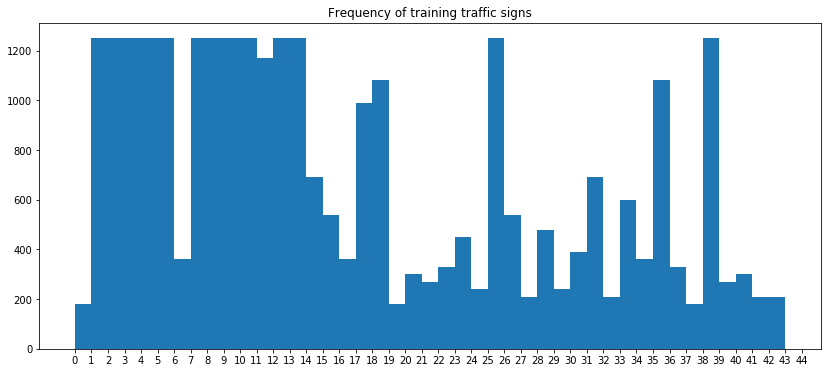

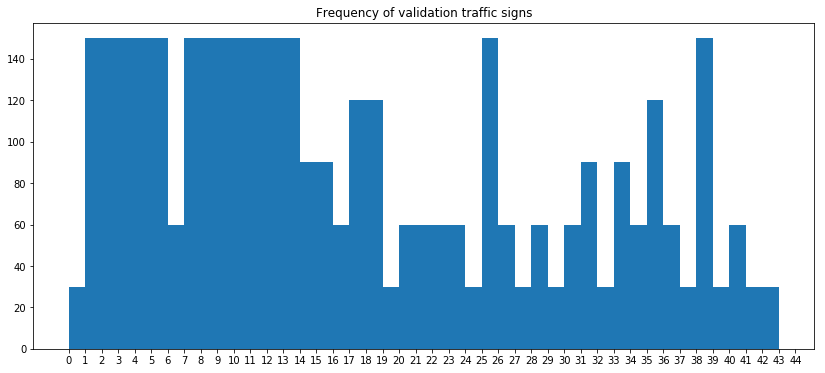

In [22]:
### Preprocess the data here. It is **required to normalize the data**. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

# Training Dataset Selection for experimentation
def select_training_dataset(selection='original'):
    if selection == 'original':
    # Original Dataset
        print('Opening the original training dataset...')
        train = pickle.load(open('traffic-signs-data/train.p',"rb"))        
        return train['features'], train['labels']

    # Trimmed Dataset
    elif selection == 'trimmed':
        print('Opening the trimmed training dataset...')
        trimmed_train = pickle.load(open('traffic-signs-data/trimmed_train.p',"rb")) 
        return trimmed_train['features'], trimmed_train['labels']
    
    elif selection == 'trimmed_500':
        print('Opening the trimmed 500 samples training dataset...')
        trimmed_500_train = pickle.load(open('traffic-signs-data/trimmed_500_train.p',"rb")) 
        return trimmed_500_train['features'], trimmed_500_train['labels']
    
    elif selection == 'trimmed_690_samples':
        print('Opening the trimmed  690 samples training dataset...')
        trimmed_690_samples_train = pickle.load(open('traffic-signs-data/trimmed_690_samples_train.p',"rb")) 
        return trimmed_690_samples_train['features'], trimmed_690_samples_train['labels']
    
    elif selection == 'trimmed_and_augmented':
        print('Opening the trimmed and augmented training dataset...')
        trimmed_and_augmented_train = pickle.load(open('traffic-signs-data/trimmed_and_augmented_train.p',"rb"))
        return trimmed_and_augmented_train['features'], trimmed_and_augmented_train['labels']

        # Generate the trimmed and augmented dataset
        # trimmed_train = pickle.load(open('traffic-signs-data/trimmed_train.p',"rb"))
        # X_augmented_train, y_augmented_train = generate_augmented_images(trimmed_train['features'],trimmed_train['labels'])
        # X_trimmed_and_augmented_train = np.concatenate((trimmed_train['features'],X_augmented_train))
        # y_trimmed_and_augmented_train = np.concatenate((trimmed_train['labels'],y_augmented_train))
        # save_dataset('trimmed_and_augmented_train.p',X_trimmed_and_augmented_train,y_trimmed_and_augmented_train)
        # return X_trimmed_and_augmented_train, y_trimmed_and_augmented_train
    
    elif selection == 'balanced':
    # Balanced Dataset
        print('Opening the balanced training dataset...')
        balanced_train = pickle.load(open('traffic-signs-data/balanced_train.p',"rb")) 
        return balanced_train['features'], balanced_train['labels']
    
    elif selection == 'balanced_500':
    # Balanced Dataset
        print('Opening the balanced 500 samples training dataset...')
        balanced_500_train = pickle.load(open('traffic-signs-data/balanced_500_train.p',"rb")) 
        return balanced_500_train['features'], balanced_500_train['labels']
    
    # Original and Augmented Dataset
    elif selection == 'original_and_augmented':
        print('Opening the original and augmented training dataset...')
        original_and_augmented_train = pickle.load(open('traffic-signs-data/original_and_augmented_train.p',"rb"))
        return original_and_augmented_train['features'], original_and_augmented_train['labels']
        
        # Generate the original and augmented dataset
        # train = pickle.load(open('traffic-signs-data/train.p',"rb"))
        # X_augmented, y_augmented = generate_augmented_images(train['features'],train['labels'])
        # X_original_and_augmented = np.concatenate((train['features'],X_augmented))
        # y_original_and_augmented = np.concatenate((train['labels'],y_augmented))
        # save_dataset('original_and_augmented_train.p',X_original_and_augmented,y_original_and_augmented)
        # return X_original_and_augmented, y_original_and_augmented
    dataset_description = selection + '_train'
    return dataset_description

# Validation Dataset Selection for experimentation
def select_validation_dataset(selection='original'):
    if selection == 'original':
    # Original Dataset
        print('Opening the original validation dataset...')
        valid = pickle.load(open('traffic-signs-data/valid.p',"rb"))        
        return valid['features'], valid['labels']
    
    # Trimmed Dataset
    elif selection == 'trimmed':
        print('Opening the trimmed validation dataset...')
        trimmed_valid = pickle.load(open('traffic-signs-data/trimmed_valid.p',"rb")) 
        return trimmed_valid['features'], trimmed_valid['labels']
    
    # Trimmed Dataset
    elif selection == 'trimmed_100':
        print('Opening the trimmed100 validation dataset...')
        trimmed_100_valid = pickle.load(open('traffic-signs-data/trimmed_100_valid.p',"rb")) 
        return trimmed_100_valid['features'], trimmed_100_valid['labels']
    
    elif selection == 'trimmed_and_augmented':
        print('Opening the trimmed and augmented training dataset...')
        trimmed_and_augmented_valid = pickle.load(open('traffic-signs-data/trimmed_and_augmented_valid.p',"rb"))
        return trimmed_and_augmented_valid['features'], trimmed_and_augmented_valid['labels']
        
        # Generate the trimmed and augmented dataset
        # trimmed_valid = pickle.load(open('traffic-signs-data/trimmed_valid.p',"rb"))
        # X_augmented_valid, y_augmented_valid = generate_augmented_images(trimmed_valid['features'],trimmed_valid['labels'])
        # X_trimmed_and_augmented_valid = np.concatenate((trimmed_valid['features'],X_augmented_valid))
        # y_trimmed_and_augmented_valid = np.concatenate((trimmed_valid['labels'],y_augmented_valid))
        # save_dataset('trimmed_and_augmented_valid.p',X_trimmed_and_augmented_valid,y_trimmed_and_augmented_valid)
        # return X_trimmed_and_augmented_valid, y_trimmed_and_augmented_valid
    
    elif selection == 'balanced':
    # Balanced Dataset
        print('Opening the balanced validation dataset...')
        balanced_valid = pickle.load(open('traffic-signs-data/balanced_valid.p',"rb")) 
        return balanced_valid['features'], balanced_valid['labels']
    
    elif selection == 'balanced_100':
    # Balanced Dataset
        print('Opening the balanced 100 samples validation dataset...')
        balanced_100_valid = pickle.load(open('traffic-signs-data/balanced_valid.p',"rb")) 
        return balanced_100_valid['features'], balanced_100_valid['labels']
    
    # Original and Augmented Dataset
    elif selection == 'original_and_augmented':
        print('Opening the original and validation augmented dataset...')
        original_and_augmented_valid = pickle.load(open('traffic-signs-data/original_and_augmented_valid.p',"rb"))        
        return original_and_augmented_valid['features'], original_and_augmented_valid['labels']
    
        # Generate the original and augmented dataset
        # valid = pickle.load(open('traffic-signs-data/valid.p',"rb"))
        # X_augmented, y_augmented = generate_augmented_images(valid['features'],valid['labels'])
        # X_original_and_augmented = np.concatenate((valid['features'],X_augmented))
        # y_original_and_augmented = np.concatenate((valid['labels'],y_augmented))
        # save_dataset('original_and_augmented_valid.p',X_original_and_augmented,y_original_and_augmented)
        # return X_original_and_augmented, y_original_and_augmented
    dataset_description = selection + '_valid'
    return dataset_description

## Trial of different combination of datasets work the best with the network traiing

# dataset name is used to used to store the trained model
# dataset_name = 'original_train_original_valid'
# dataset_name = 'trimmed_train_original_valid'
dataset_name = 'trimmed_train_trimmed_valid'
# dataset_name = 'trimmed_690_samples_train_trimmed_valid'
# dataset_name = 'trimmed_500_samples_train_trimmed_100_valid'
# dataset_name = 'balanced_train_original_valid'
# dataset_name = 'balanced_train_trimmed_valid'
# dataset_name = 'original_and_augmented_train_original_valid'
# dataset_name = 'balanced_train_balanced_valid'
# dataset_name = 'original_and_augmented_train_original_and_augmented_valid'
# dataset_name = 'trimmed_and_augmented_train_original_valid'
# dataset_name = 'trimmed_and_augmented_train_trimmed_and_augmented_valid'
# dataset_name = 'trimmed_and_augmented_train_trimmed_valid'
# dataset_name = 'balanced_500_train_balanced_100_valid'

# Training dataset selection
# X_train, y_train = select_training_dataset(selection='original') # Original Dataset
X_train, y_train = select_training_dataset(selection='trimmed') # Trimmed Dataset
# X_train, y_train = select_training_dataset(selection='trimmed_500') # Trimmed Dataset
# X_train, y_train = select_training_dataset(selection='trimmed_690_samples') # Trimmed 690 samples Dataset
# X_train, y_train = select_training_dataset(selection='trimmed_and_augmented') # Trimmed Dataset
# X_train, y_train = select_training_dataset(selection='balanced') # Balanced Dataset
# X_train, y_train = select_training_dataset(selection='balanced_500') # Balanced Dataset
# X_train, y_train = select_training_dataset(selection='original_and_augmented') # Original and augmented Dataset

# Validation dataset selection
# X_valid, y_valid = select_validation_dataset(selection='original') # Original Dataset
X_valid, y_valid = select_validation_dataset(selection='trimmed') # Trimmed Dataset
# X_valid, y_valid = select_validation_dataset(selection='trimmed_100') # Trimmed Dataset
# X_valid, y_valid = select_validation_dataset(selection='trimmed_and_augmented') # Trimmed Dataset
# X_valid, y_valid = select_validation_dataset(selection='balanced') # Balanced Dataset
# X_valid, y_valid = select_validation_dataset(selection='balanced_100') # Balanced Dataset
# X_valid, y_valid = select_validation_dataset(selection='original_and_augmented') # Original and augmented Dataset

# Load the test dataset
testing_file    = 'traffic-signs-data/test.p'
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
X_test,  y_test  = test['features'], test['labels']

# Summary of datasets for image classification
show_dataset_summary(y_train,title='Frequency of training traffic signs')
show_dataset_summary(y_valid,title='Frequency of validation traffic signs')

def normalize_image(img):
    # Normalize datasets to [-1 to 1]
    img = (img-128)/255 #Udacity Q&A recommend this method
    #img = (img-128)/128
    return img

def RGB2grayscale(img):
    # Convert RGB image to grayscale
    img = np.sum(img/3, axis=3, keepdims=True)
    return img

def preprocess(img):
    img = RGB2grayscale(img)
    img = normalize_image(img)
    print('Dataset shape:', img.shape)
    return img

print('')
print('Preprocessing the training dataset...')
X_train = preprocess(X_train)
print('Preprocessing the validation dataset...')
X_valid = preprocess(X_valid)
print('Preprocessing the testing dataset...')
X_test  = preprocess(X_test)

# Shuffle the training data (for generalizing the learning)
X_train, y_train = shuffle(X_train, y_train)
    
# show_first_x_random_traffic_signs(X_train,y_train,signnames,10)

### Model Architecture

In [27]:
# LeNet Architecture for recognizing 43 classes
def LeNet(x):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation
    fc1    = tf.nn.relu(fc1)
    # Added dropout for generalizing learning (avoid overfitting)
    fc1 = tf.nn.dropout(fc1,keep_prob)
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation
    fc2    = tf.nn.relu(fc2)
    # Added dropout for generalizing learning (avoid overfitting)
    fc2 = tf.nn.dropout(fc2,keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing.
- A **low accuracy** on the training and validation sets imply **underfitting**.
- A **high accuracy** on the training set but **low accuracy** on the validation set implies **overfitting**.

```
|             | Training      | Validation   |
|:-----------:|:-------------:|:------------:|
| Underitting | low accuracy  | ?            |
| Overfitting | high accuracy | low accuracy |
Table generated from https://www.tablesgenerator.com/markdown_tables#
```

## Training Pipeline
Create a training pipeline that uses the model to classify traffic sign.

- Train your model here.
- Calculate and report the accuracy on the training and validation set.
- Once a final model architecture is selected, the accuracy on the test set should be calculated and reported as well.
Feel free to use as many code cells as needed.


- First, we have another hyperparameter to tune. 
- The learning rate tells TensorFlow how quickly to update the network's weights. 0.001 is a good default value but you can experiment with other rates and see how they do. 

In [28]:
# Set up placeholder to feed in the data

# Network takes 32x32 input
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))

# Network to recognize up to 43 classes of classification
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(dtype=tf.float32) # probability to keep units

rate = 0.001

# Define the training and validation operation
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

In [29]:
# Operation to find correct prediction and its accuracy
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

BATCH_SIZE = 256
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

In [ ]:
# Great! Now that everything else is set up, we can build a function to train and validate our model. 
# First, we create the TensorFlow session and initialize the variables.

saved_model = trained_model_folder + dataset_name + '_lenet'

save_every_epoch = False

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []
train_results = {}
train_results['dataset_name'] = dataset_name

EPOCHS = 26

resume_training = False

with tf.Session() as sess:
    if resume_training:
        # Restore the previously trained model to experiment training
        saver.restore(sess,saved_model)
    else:
        # Initalize the random weights at the beginning of the training with the specified mean and sigma
        sess.run(tf.global_variables_initializer())
    
    num_examples = len(X_train)
    
    print("Training...")
    print("TOTAL_EPOCHS = ",EPOCHS)
    print('BATCH_SIZE =',BATCH_SIZE)
    print('rate =',rate)
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            epoch_loss_avg = sess.run(loss_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        
        # Option to save every epoch
        if save_every_epoch:
            # Save the network at the end of every epoch
            epoch_progress = '_epoch_'+ str(i+1) + '_of_' + str(EPOCHS) + '_lenet'
            sess_name = trained_model_folder + dataset_name + epoch_progress
            saver.save(sess,sess_name)    
                
        # Save the training loss and accuracy
        train_loss_results.append(epoch_loss_avg)
        train_accuracy_results.append(validation_accuracy)
        
        train_results['train_loss'] = train_loss_results
        train_results['accuracy'] = train_accuracy_results
    
        # Save training results log to a pickle
        train_results_log = trained_model_folder + dataset_name + '_lenet.p'
        pickle.dump(train_results, open(train_results_log, "wb" ))
        
        #show_training_metrics(train_results['train_loss'],train_results['accuracy'],train_results['dataset_name'])
    
    # Save the training model
    sess_name = trained_model_folder + dataset_name + '_lenet'
    print("Saving training model... {}".format(sess_name))
    saver.save(sess,sess_name)
    
    # Save training results log to a pickle
    train_results_log = trained_model_folder + dataset_name + '.p'
    pickle.dump(train_results, open(train_results_log, "wb" ))
        
# Show training progress
show_training_metrics(train_loss_results,train_accuracy_results,dataset_name)

# [Optional]: Save the training dataset used in the current training session
save_current_session_training_dataset = False
if save_current_session_training_dataset:
    train = {}
    train['features'] = X_train
    train['labels'] = y_train

    print('Saved the the last used training dataset to the ""traffic-signs-data" folder')
    pickle.dump(train, open("traffic-signs-data/saved_last_training_dataset.p", "wb" ))

### Restore Tensorflow for validation and test accuracy

In [39]:
# Path of saved trained model
saved_model = trained_model_folder + dataset_name + '_lenet'

# Load the previously training loss and accuracy
train_results_log = trained_model_folder + dataset_name + '_lenet.p'
train_results = pickle.load(open(train_results_log,"rb"))

# Show previous training metrics
# show_training_metrics(train_results['train_loss'],train_results['accuracy'],train_results['dataset_name'])

# Restore variables to the Tensorflow model
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.

saver = tf.train.Saver()
with tf.Session() as sess:
    # Restore the previous trained model
    saver.restore(sess,saved_model)
    
    # Validation Accuracy
    validation_accuracy = evaluate(X_valid, y_valid)
    print("Validation Accuracy = {:.3f}".format(validation_accuracy))
    
    # Test Accuracy
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from trained_models/best/trimmed_train_trimmed_valid_lenet
Validation Accuracy = 0.959
Test Accuracy = 0.915


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

Opening the new test image dataset...
Preprocessing the new test image dataset...
Dataset shape: (6, 32, 32, 1)


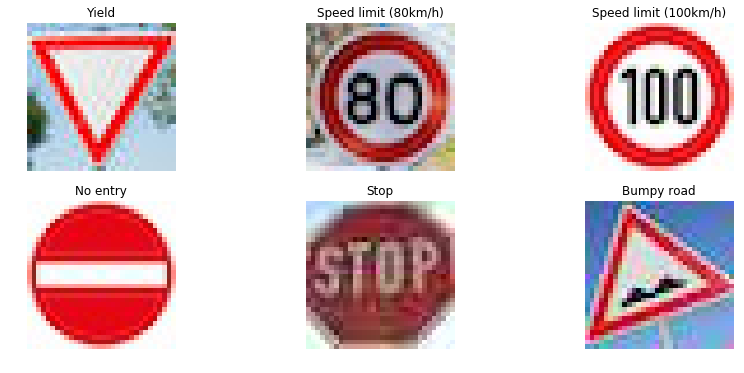

In [40]:
def load_new_test_data():
    # Read test images
    new_images = []
    new_images.append(mpimg.imread('test_images/class_13_Yield_1.jpg'))
    new_images.append(mpimg.imread('test_images/class_5_Speed_limit_80_km_hr.jpg'))
    new_images.append(mpimg.imread('test_images/class_7_Speed_limit_100_km_hr.jpg'))
    new_images.append(mpimg.imread('test_images/class_17_No_Entry.jpg'))
    new_images.append(mpimg.imread('test_images/class_14_Stop_sign_1.jpg'))
    new_images.append(mpimg.imread('test_images/class_22_Bumpy_road_sign.jpg'))
    
    # Create new dataset for the test images
    new_test = {}
    new_test['features'] = np.array(new_images)
    new_test['labels'] = [13, 5, 7, 17, 14, 22]
    return new_test

def show_test_data(new_test,signnames):
    cols = 3
    rows = len(new_test['labels'])//cols

    fig, ax = plt.subplots(rows,cols, figsize=(15, 6))
    fig.subplots_adjust(hspace = .2, wspace=.001)
    ax = ax.ravel()

    # Loop through each random sampled image
    for i in range(len(new_test['labels'])):
        # Retrive image and label
        img = new_test['features'][i].squeeze()
        class_index = new_test['labels'][i]
        
        # Lookup traffic sign description
        class_description = signnames['class_description'][class_index]
        
        ax[i].set_title(class_description)
        ax[i].imshow(img,cmap='gray')
        ax[i].axis('off')

# Load the hand picked test images found online
print('Opening the new test image dataset...')
new_test = load_new_test_data()

# Preprocess the new image dataset with the same preprocessing
# used with the training and validation dataset
print('Preprocessing the new test image dataset...')
X_new_test = preprocess(new_test['features'])

# Display the new test images
show_test_data(new_test,signnames)

### Predict the Sign Type for Each Image

### Analyze Performance

In [41]:
# Define Softmax probabilities for multi-class classifications operation
softmax_logits = tf.nn.softmax(logits)

# Define top 5 Softmax probabilities operation
top_k = tf.nn.top_k(softmax_logits, k=5)  

saver = tf.train.Saver()
with tf.Session() as sess:
    # Restore the previous training session
    saver.restore(sess,saved_model)
    
    # Test Accuracy
    test_accuracy = evaluate(X_new_test, new_test['labels'])
    print('')
    print("Test Accuracy for the new images= {:.3f}".format(test_accuracy))
    print('')
    
    # Run the operations to predict the closest match traffic sign classifications
    softmax_results = sess.run(softmax_logits,feed_dict={x: X_new_test, keep_prob: 1.0})
    top_k_results = sess.run(top_k, feed_dict={x: X_new_test, keep_prob: 1.0})

# Softmax probabilities
top_k_softmax = top_k_results[0]

# Array index of the corresponding Softmax probabilities
top_k_indices = top_k_results[1]

for i in range(len(top_k_indices)):
    # Ground truth of the new test images
    ground_truth_class_index = new_test['labels'][i]
    ground_truth_name = signnames['class_description'][ground_truth_class_index]
    
    # First guess
    first_guess_index = top_k_indices[i][0]
    first_guess = signnames['class_description'][first_guess_index]
    accuracy = top_k_softmax[i][0]
    
    if first_guess_index == ground_truth_class_index:
        prediction_status = 'correct'
    else:
        prediction_status = 'FAILED'
    
#     print('Predicting Image #{}: {} {}'.format(i+1,ground_truth_name,prediction_status))
#     print('-->{:.0f}% certain that it is a "{}" sign'.format(accuracy*100,first_guess))
#     print('')

INFO:tensorflow:Restoring parameters from trained_models/best/trimmed_train_trimmed_valid_lenet

Test Accuracy for the new images= 0.833



### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

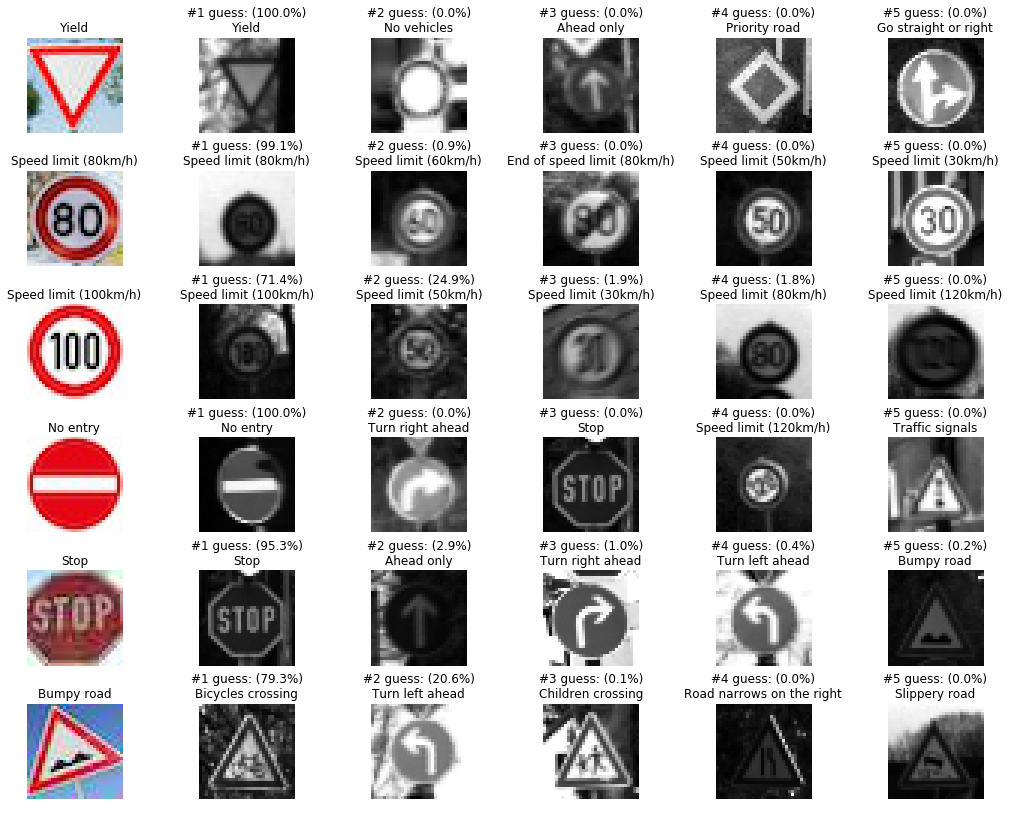

In [42]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 

def show_traffic_sign_predictions(X_test,y_test,new_test,top_k_softmax,top_k_indices):
    
    num_test_images = len(new_test['labels'])
    num_guesses = len(top_k_indices[0])
    
    # Setup the figure grid
    row = num_test_images
    cols = num_guesses + 1
    fig, ax = plt.subplots(num_test_images,cols, figsize=(18, 14))
    fig.subplots_adjust(hspace = 0.4, wspace=.2)
    ax = ax.ravel()

    # Show comparison of ground truth data and predictions
    for i in range(num_test_images):
        # Show ground truth data
        ax[cols*i].axis('off')
        ax[cols*i].imshow(new_test['features'][i])
        ground_truth_class_index = new_test['labels'][i]
        ax[cols*i].set_title(signnames['class_description'][ground_truth_class_index])
        
        # Show the traffic sign predictions
        for guess_index in range (len(top_k_indices[0])):
            guess = top_k_indices[i][guess_index]
            shuffle_index = np.random.randint(guess_index,np.argwhere(y_test == guess).size)
            index = np.asscalar(np.argwhere(y_test == guess)[shuffle_index])
            #index = np.asscalar(np.argwhere(y_test == guess)[guess_index])
            guess_class_index = y_test[index]
            guess_class_description = signnames['class_description'][guess_class_index]
            ax[cols*i+1+guess_index].set_title('#{} guess: ({:.1f}%)\n{}'.format(guess_index+1,top_k_softmax[i][guess_index]*100,guess_class_description))
            ax[cols*i+1+guess_index].axis('off')
            ax[cols*i+1+guess_index].imshow(X_test[index].squeeze(), cmap='gray')

# Show traffic sign predictions
show_traffic_sign_predictions(X_test,y_test,new_test,top_k_softmax,top_k_indices)

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a **black box**. We can __understand what the weights of a neural network look like better by plotting their feature maps__. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. 
 
For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

Provided for you below is the `function` code that allows you to get the **visualization output of any tensorflow weight layer you want**. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the LeNet lab's feature maps looked like for it's second convolutional layer, you could enter `conv2` as the `tf_activation` variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section `Visualization of internal CNN State`. NVIDIA was able to show that their network's **inner weights had high activations to road boundary lines** by comparing feature maps from an image with a clear path to one without.

**Try experimenting** with a similar test to **show that your trained network's weights are looking for interesting features**, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 

In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

### Suggestions to Make Your Project Stand Out!

#### AUGMENT THE TRAINING DATA
`Augmenting the training set` might help improve model performance. Common data augmentation techniques include `rotation`, `translation`, `zoom`, `flips`, and/or `color perturbation`. These techniques can be used individually or combined.

#### ANALYZE NEW IMAGE PERFORMANCE IN MORE DETAIL
Calculating the accuracy on these 5 German traffic sign images found on the web might not give a comprehensive overview of how well the model is performing.

Consider ways to do a **more detailed analysis of model performance** by looking at predictions in more detail. For example, calculate the `precision` and `recall` for each traffic sign type from the test set and then compare performance on these 5 new images.

If one of the new images is a stop sign but was predicted to be a bumpy road sign, then we might expect a `low recall` for stop signs. In other words, the model has `trouble predicting` on stop signs.

If one of the new images is a 100 km/h sign but was predicted to be a stop sign, we might expect `precision to be low` for stop signs. In other words, if the model says something is a stop sign, we're `not very sure that it really is` a stop sign.

**Looking at performance of individual sign types** can help guide how to **better augment** the data set or how to fine tune the model.

#### CREATE VISUALIZATIONS OF THE SOFTMAX PROBABILITIES
For each of the five new images, **create a graphic visualization** of the soft-max probabilities. **Bar charts** might work well.

#### VISUALIZE LAYERS OF THE NEURAL NETWORK
See Step 4 of the Iptyon notebook for details about how to do this.